In [42]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [43]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path #good for path/data loadings
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(3)          #this is for assigning the gpu's while working on multiple gpu's

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

#PASCAL is a standard library for object detection like image net for classification

In [ ]:
PATH = Path('data/pascal')  #assigning a path from which we can retreive more info..
list(PATH.iterdir())

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [16]:
#json file has details about annotations with bounding box and category for each image
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()
trn_j.values()

dict_values([[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}, {'file_name': '000033.jpg', 'height': 366, 'width': 500, 'id': 33}, {'file_name': '000034.jpg', 'height': 500, 'width': 360, 'id': 34}, {'file_name': '000035.jpg', 'height': 375, 'width': 500, 'id': 35}, {'file_name': '000036.jpg', 'height': 500, 'width': 332, 'id': 36}, {'file_name': '000042.jpg', 'height': 335, 'width': 500, 'id': 42}, {'file_name': '000044.jpg', 'height': 333, 'width': 500, 'id': 44}, {'file_name': '000047.jpg', 'height': 333, 'width': 500, 'id': 47}, {'file_name': '000048.jpg', 'height': 500, 'width': 375, 'id': 48}, {'file_name': '000061.jpg', 'height': 333, 'width': 500, 'id': 61}, {'file_name': '000064.jpg', 'heigh

In [15]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5] #top5 image details

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [36]:
#trn_j['categories'][1]#['supercategory']

{'supercategory': 'none', 'id': 2, 'name': 'bicycle'}

In [44]:
trn_j[ANNOTATIONS][:2] #annotations here is bounding box with col,row,ht,wdth->[155, 96, 196, 174] of bb

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [45]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [46]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [70]:
list(PATH.iterdir())

[WindowsPath('data/pascal/pascal_test2007.json'),
 WindowsPath('data/pascal/pascal_train2007.json'),
 WindowsPath('data/pascal/pascal_train2012.json'),
 WindowsPath('data/pascal/pascal_val2007.json'),
 WindowsPath('data/pascal/pascal_val2012.json'),
 WindowsPath('data/pascal/VOCtrainval_11-May-2012.tar')]

In [73]:
import subprocess
args = ["tar","-xzvf",'VOCtrainval_11-May-2012.tar']
p=subprocess.Popen(args)
p.wait()

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [47]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\pascal\\VOCdevkit\\VOC2007'

In [10]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [11]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005475.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001898.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006004.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006660.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005067.jpg')]

Each image has a unique ID.

In [12]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [39]:
#bounding box in h.t & w.d.t
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])  #bb[1],bb[0] -because we are changing into h.t*w.d.t format like numpy

trn_anno = collections.defaultdict(lambda:[])   #collections.defalt... makes/returns an non-available values with an empy list
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
       
len(trn_anno)

NameError: name 'BBOX' is not defined

In [14]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [15]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [16]:
cats[7]

'car'

In [17]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [18]:
cats[15],cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [21]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [24]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [25]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to find out all about the `open_image` function. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Select interpreter (for fastai env)
- Select terminal shell
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F12</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

In [20]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [20]:
#basically returns the image with axis off 

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [21]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [22]:
#all these functions are addidng extra features to the object ax

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [23]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

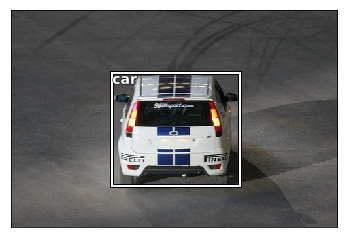

In [25]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])  #b[:2] gives first 2 vales i.e. top left co-ordinates t write text,cats to get categoryname

In [26]:
#summing up all functions above for object detection
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [27]:
#testing out object detection in random from dataset
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


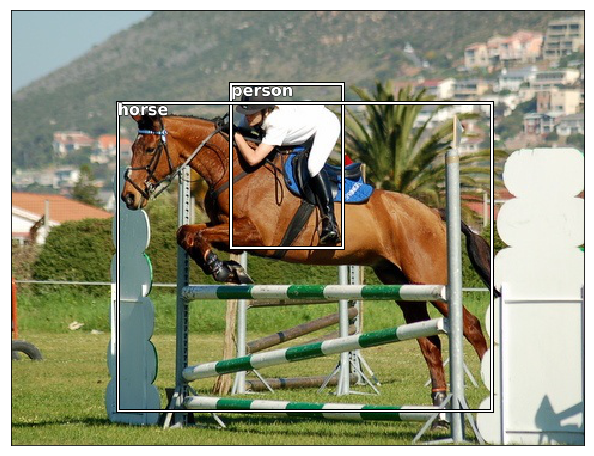

In [28]:
draw_idx(17)

## Largest item classifier

A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [25]:
#this gives out largest bounding box in a image sorting in decreasing order with product of topleft-bottomright bb

def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True) ##x[0][-2:]-last 2 values of bb i.e. bottom right ;x[0][:2]-first two values i.e. top left bb subtract of these gives size of bounding box(bb) 
    return b[0]

In [26]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

Now we have a dictionary from image id to a single bounding box - the largest for that image.

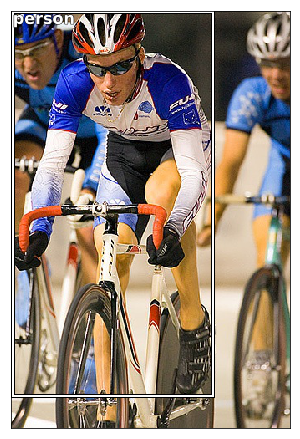

In [215]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [27]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [28]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [29]:
f_model = resnet34
sz=224
bs=64

From here it's just like Dogs vs Cats!

In [30]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO) #Here we aren't cropping image to 224*244 instead we are squeezing to not miss out edged objects
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [201]:
x,y=next(iter(md.val_dl))

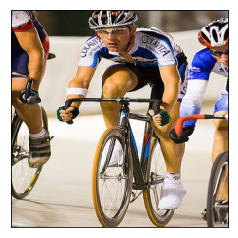

In [31]:
show_img(md.val_ds.denorm(to_np(x))[0]);
#Here we are trying to dispaly image from a mini batch of data loader which is in datamodel object which is normalisedand in cv format
#as now data object has values of normalised due to tfms use denorm for original values to_np for getting in original numpy wd.t*h.t

In [220]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [ ]:
lrf=learn.lr_find(1e-5,100)

When you LR finder graph looks like this, you can ask for more points on each end:

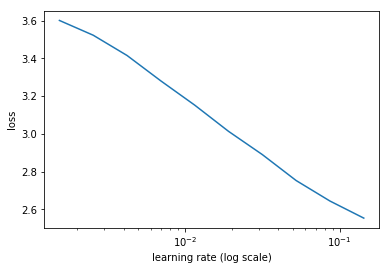

In [36]:
learn.sched.plot()

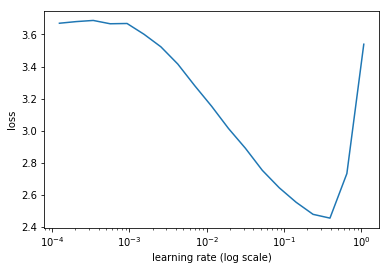

In [35]:
learn.sched.plot(n_skip=5, n_skip_end=1) #in general we skip first & last 10 mini batches as it goes till infinity,  but we can change them with n_skip

In [43]:
lr = 2e-2

In [44]:
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.335532   0.6443     0.804838  



[0.6443001, 0.80483774095773697]

In [45]:
lrs = np.array([lr/1000,lr/100,lr])

In [46]:
learn.freeze_to(-2)

A Jupyter Widget

 84%|████████▍ | 27/32 [00:07<00:01,  3.76it/s, loss=4.99] 


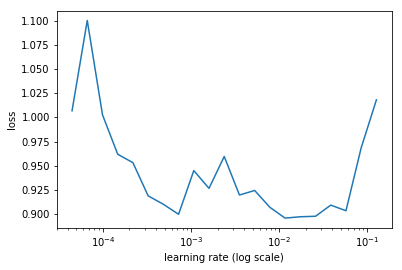

In [39]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [47]:
learn.fit(lrs/5, 1, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.780925   0.575539   0.821064  



[0.57553864, 0.82106370478868484]

In [48]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [49]:
learn.fit(lrs/5, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                  
    0      0.609306   0.570568   0.821514  
    1      0.462856   0.574303   0.8128                    



[0.57430345, 0.81280048191547394]

In [51]:
learn.save('clas_one')

In [221]:
learn.load('clas_one')

In [222]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint  write this before the code that needs to be debugged
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c  n-(next) s-(step inside the line of current code)
- u / d
- p (print)
- l
- q (quit)

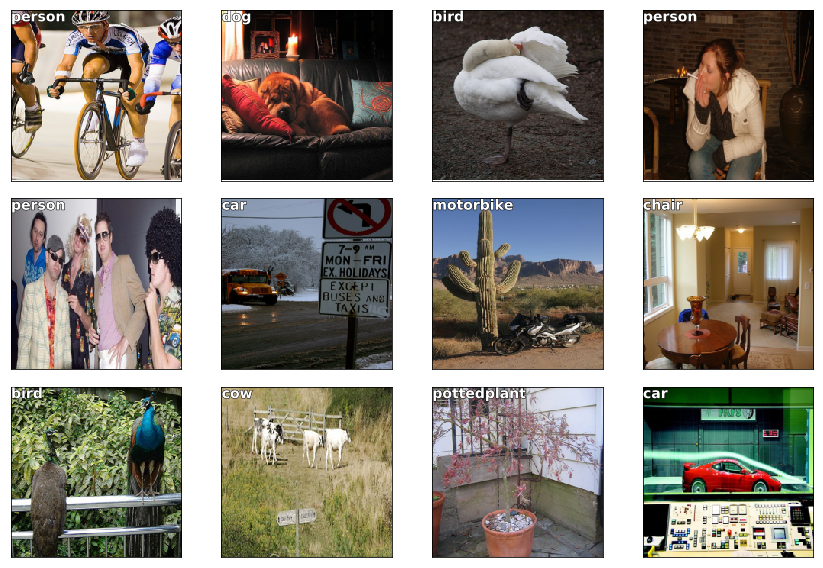

In [223]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

Bounding box is nothing but a 4 continous numbers [Topleft,bottom right co-ords] so pass on this to a n-n/w to return best values which is perfectly fitting the label i.e. minimum mean squared error

In [31]:
BB_CSV = PATH/'tmp/bb.csv'

In [32]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]  #space separating 4 bb's

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox']) #creating a a table with id and bb 
df.to_csv(BB_CSV, index=False)

In [33]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [34]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [58]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [59]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]
[ 115.   63.  240.  311.]


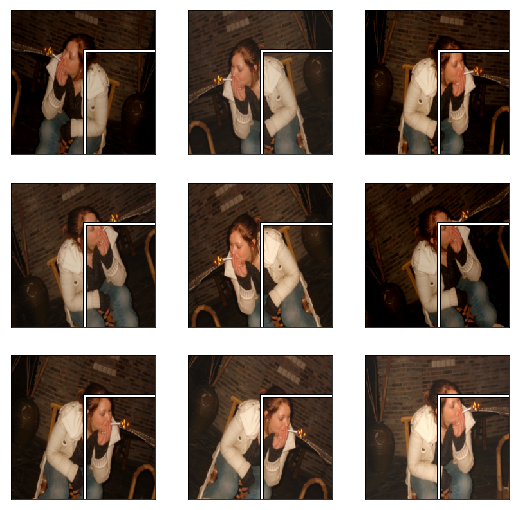

In [60]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [61]:
#COCORD-coordinates,tfm-y says augment the y value according to x value so the we dont miss out bb like above
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [62]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[  48.   34.  112.  188.]
[  65.   36.  107.  185.]
[  49.   27.  131.  195.]
[  24.   18.  147.  204.]
[  61.   34.  113.  188.]
[  55.   31.  121.  191.]
[  52.   19.  144.  203.]
[   7.    0.  193.  222.]
[  52.   38.  105.  182.]


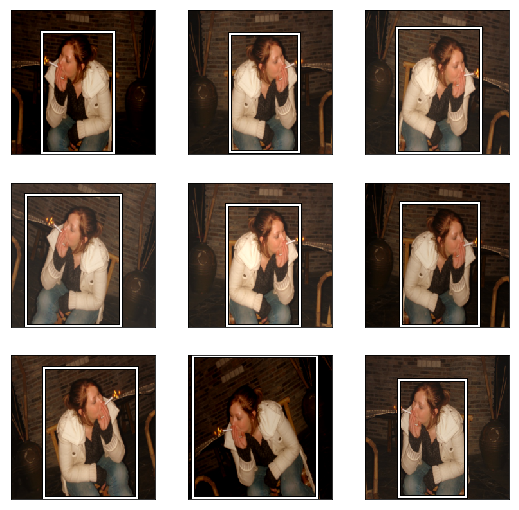

In [63]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [65]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [66]:
512*7*7

25088

In [168]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4)) #here custom adding a layer which flattens first layer to a single vector and a linear layer 25088 rows with 4 o/p values
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)  #custom_head is something that adds on top of model instead of final F.C layer
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss() #L1 loss takes out actual error instead of squared error , as squared error is increasing -ve errors

In [170]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

A Jupyter Widget

 78%|███████▊  | 25/32 [00:04<00:01,  6.16it/s, loss=395] 


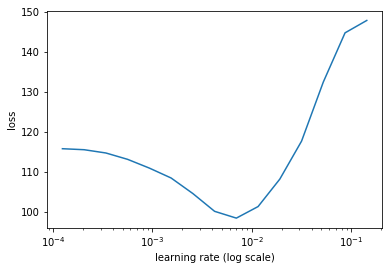

In [147]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [151]:
lr = 2e-3

In [152]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      49.523444  34.764141 
    1      36.864003  28.007317                           
    2      30.925234  27.230705                           



[27.230705]

In [153]:
lrs = np.array([lr/100,lr/10,lr])

In [154]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                                                                         
    0      102.406115 91141120000.0



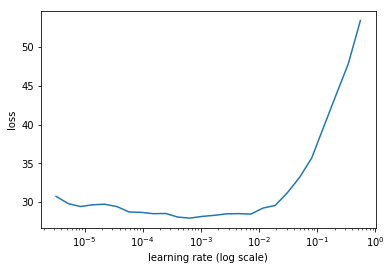

In [106]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [155]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      25.616161  22.83597  
    1      21.812624  21.387115                           
    2      17.867176  20.335539                           



[20.335539]

In [156]:
learn.freeze_to(-3)

In [157]:
learn.fit(lrs, 1, cycle_len=2)

A Jupyter Widget

epoch      trn_loss   val_loss                            
    0      16.571885  20.948696 
    1      15.072718  19.925312                           



[19.925312]

In [158]:
learn.save('reg4')

In [89]:
learn.load('reg4')

In [97]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

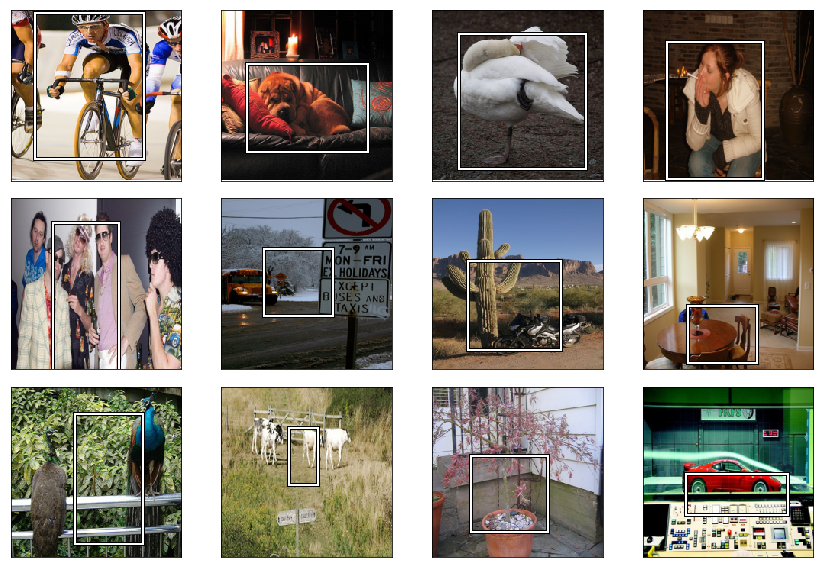

In [99]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

#Here we are combining the idea of label with bounding box for that we are combining datsets of label,bb with ConcatLblDataset

In [67]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [80]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [81]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [82]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [83]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [84]:
val_ds2[0][1]

(array([   0.,   49.,  205.,  180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [85]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [86]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([  52.,   38.,  106.,  184.], dtype=float32)

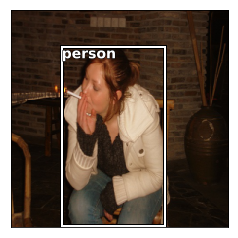

In [87]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [88]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [89]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy_np(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

A Jupyter Widget

 97%|█████████▋| 31/32 [00:07<00:00,  4.32it/s, loss=920]


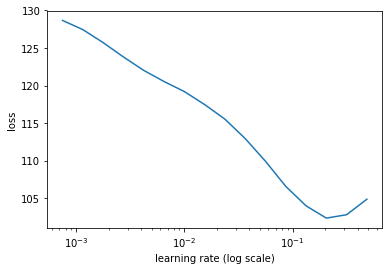

In [171]:
learn.lr_find()
learn.sched.plot()

In [90]:
lr=1e-2

In [51]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      72.036466  45.186367  0.802133   32.647586 
    1      51.037587  36.34964   0.828425   25.389733     
    2      41.4235    35.292709  0.835637   24.343577     



[35.292709, 0.83563701808452606, 24.343576669692993]

In [52]:
learn.save('reg1_0')

In [53]:
learn.freeze_to(-2)

In [54]:
lrs = np.array([lr/100, lr/10, lr])

A Jupyter Widget

 91%|█████████ | 29/32 [00:09<00:01,  2.99it/s, loss=308] 


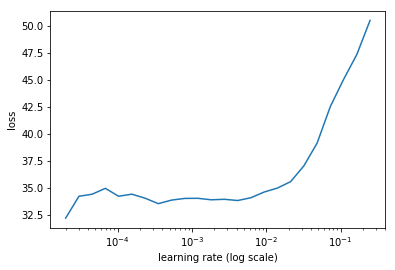

In [185]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [55]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      34.448113  35.972973  0.801683   22.918499 
    1      28.889909  33.010857  0.830379   21.689888     
    2      24.237017  30.977512  0.81881    20.817996     
    3      21.132993  30.60677   0.83143    20.138552     
    4      18.622983  30.54178   0.825571   19.832196     



[30.54178, 0.82557091116905212, 19.832195997238159]

In [56]:
learn.save('reg1_1')

In [353]:
learn.load('reg1_1')

In [57]:
learn.unfreeze()

In [58]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

A Jupyter Widget

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.957164  31.111507  0.811448   19.970753 
    1      15.955259  32.597153  0.81235    20.111022     
    2      15.648723  32.231941  0.804087   19.522853     
    3      14.876172  30.93821   0.815805   19.226574     
    4      14.113872  31.03952   0.808594   19.155093     
    5      13.293885  29.736671  0.826022   18.761728     
    6      12.562566  30.000023  0.827524   18.82006      
    7      11.885125  30.28841   0.82512    18.904158     
    8      11.498326  30.070133  0.819712   18.635296     
    9      11.015841  30.213772  0.815805   18.551489     



[30.213772, 0.81580528616905212, 18.551488876342773]

In [59]:
learn.save('reg1')

In [108]:
learn.load('reg1')

In [60]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [61]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


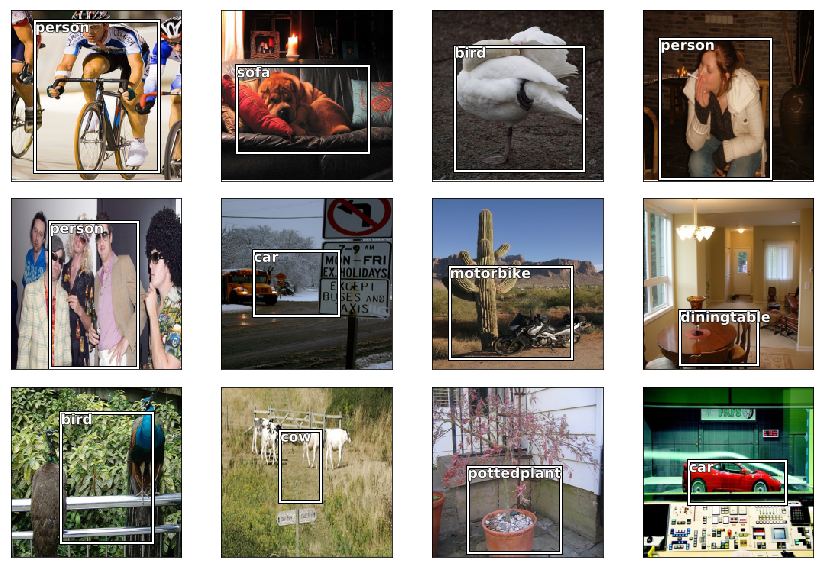

In [62]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## End